
#### <center> Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

### <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам <br>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import datetime

In [2]:
#путь к данным
PATH_TO_DATA = ('capstone_user_identification')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    
    window_size = 10 #ширина окна
    site_freq_dict = {} # частотный словарь
    data = [] #массив с индексами сайтов по сессиям
    sites_seq = [] #список сайтов для каждого пользователя    
    start_session_index = 0 #индекс начала следующей сессии в зависимости от ширины окна 
    
    session_timespan = [] #продолжительностей сессии
    min_time = 0 #время начала сессии
    max_time = 0 #время окончания сессии
    unique_sites = 0 #число уникальных сайтов в сессии
    start_hour = 0 #час начала сессии
    day_of_week = 0 #день начала сессии
    timestamps = [] #массив времен посещений сайтов
    
    
    #считывание частотного словаря из файла
    with open(site_freq_path, 'rb') as f:
        site_freq_dict = pickle.load(f)
    
    #считывание файлов с данными
    for user_id, path_to_file in enumerate(glob(path_to_csv_files + '/*.csv')):
        user_id += 1
        with open(path_to_file) as file: 
            lines = file.readlines()[1:] #пропуск первой строки-заголовка
            #заполнение списка сайтов сессии и списка времен для пользователя
            for i, line in enumerate(lines):
                site = line.strip().split(',')[1]
                sites_seq.append(site)
                time = line.strip().split(',')[0]
                timestamps.append(pd.to_datetime(time))
                
        #заполнение массива id сайтов
        while start_session_index < len(lines):
            session_end = len(lines)\
                        if start_session_index + session_length > len(lines) - 1 \
                        else start_session_index + session_length
            #заполнение новых признаков
            min_time = timestamps[start_session_index]
            max_time = timestamps[session_end-1] 
            session_timespan = int((max_time-min_time).total_seconds())
            start_hour = min_time.hour
            day_of_week = min_time.weekday()
            #получение списка id сайтов без нулей
            sites = list(site_freq_dict[i][0] for i in sites_seq[start_session_index:session_end])
            unique_sites = len(set(sites))
            
            #если это последняя сессия пользователя, то ее длина может быть не равна session_length
            #в таком случаем происходит заполнение оставшихся индексов нулями
            sites_id = sites + [0 for i in range(session_length - session_end + start_session_index)] 
            
            #добавление в массив id сайтов и новых признаков
            data.append(sites_id+[session_timespan]+[unique_sites]+[start_hour]+[day_of_week]+[user_id])
 
            start_session_index += window_size            
        
        start_session_index = 0  
        sites_seq = []
        timestamps = []
    
    #создание датафрейма 
    df = pd.DataFrame(data, columns = feature_names, dtype=object)
    df = df.fillna(0)
    
    return df

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', 'unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                                               site_freq_path = os.path.join(PATH_TO_DATA, 
                                                                             'site_freq_10users.pkl'),
                                               feature_names = feature_names, 
                                               session_length = 10)

CPU times: user 8.73 s, sys: 13.1 ms, total: 8.74 s
Wall time: 8.75 s


In [7]:
train_data_10users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,33,5,8,4,1
1,415,193,674,254,133,31,393,3305,217,55,284,10,8,4,1
2,55,3,55,55,5,293,415,333,897,55,258,7,8,4,1
3,473,3306,473,55,55,55,55,937,199,123,30,6,8,4,1
4,342,55,5,3307,258,211,3308,2086,675,2086,6,9,8,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,23,9,9,23,28,4,9,23,28,9,791,4,15,1,10
14057,23,28,4,9,28,23,9,28,28,23,720,4,15,1,10
14058,9,23,28,9,23,6,51,4,9,23,164,6,16,1,10
14059,9,6,23,9,9,28,4,51,28,28,26,6,16,1,10


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                                               site_freq_path = os.path.join(PATH_TO_DATA, 
                                                                             'site_freq_150users.pkl'),
                                               feature_names = feature_names, 
                                               session_length = 10)

CPU times: user 1min 26s, sys: 72.2 ms, total: 1min 26s
Wall time: 1min 26s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features = ['session_timespan', 'unique_sites', 'start_hour', 'day_of_week']

In [10]:
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [12]:
id_name_dict = {0: 'Mary-Kate', 1: 'Ashley', 2: 'Lindsey', 3: 'Naomi', 4: 'Avril',
               5: 'Bob', 6: 'Bill', 7: 'John', 8: 'Dick', 9: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [13]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

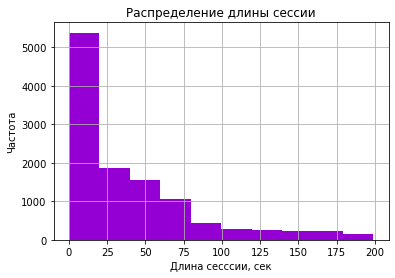

In [14]:
train_data_10users[train_data_10users.session_timespan < 200]['session_timespan'].hist(color = 'darkviolet')
plt.ylabel('Частота')
plt.xlabel('Длина сесссии, сек')
plt.title('Распределение длины сессии')
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

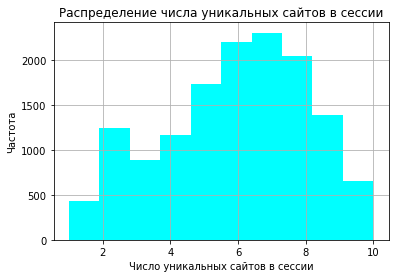

In [15]:
train_data_10users['unique_sites'].hist(color = 'aqua')
plt.ylabel('Частота')
plt.xlabel('Число уникальных сайтов в сессии')
plt.title('Распределение числа уникальных сайтов в сессии')
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

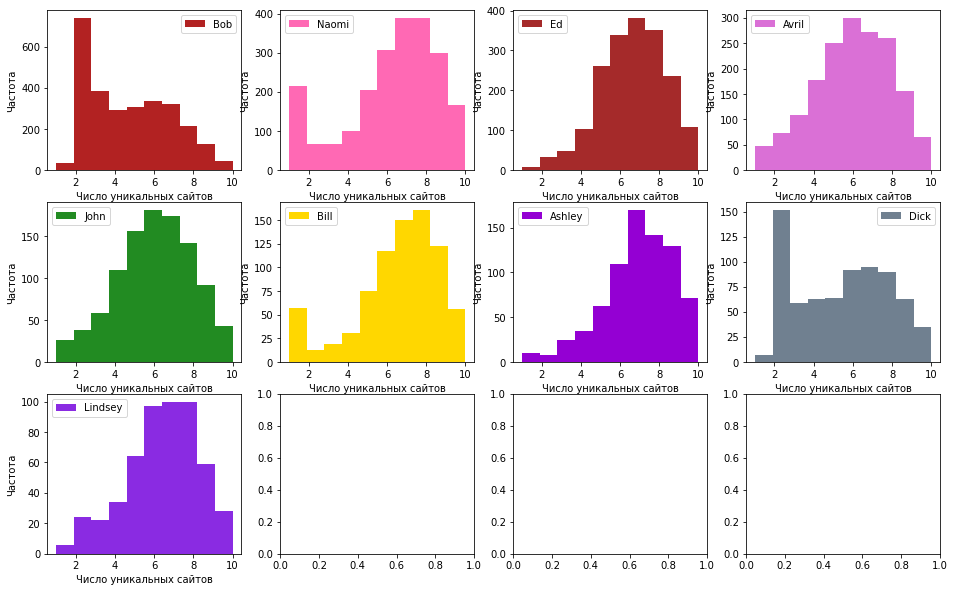

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

users = train_data_10users['target'].value_counts().index.to_list()
# как вариант, можно и по-другому
for idx, user in  enumerate(users):
    train_data_10users[train_data_10users['target']==user]['unique_sites'].plot(kind='hist', ax=axes[idx//4][idx%4], color=color_dic[user], legend=True)
    axes[idx//4, idx%4].set_xlabel('Число уникальных сайтов')
    axes[idx//4, idx%4].set_ylabel('Частота')
    axes[idx//4, idx%4].legend([user])

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

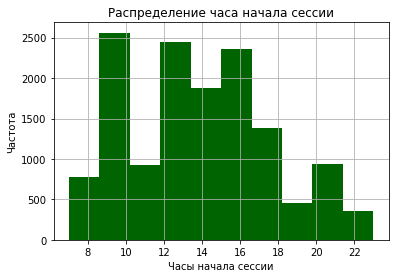

In [17]:
train_data_10users['start_hour'].hist(color = 'darkgreen')
plt.ylabel('Частота')
plt.xlabel('Часы начала сессии')
plt.title('Распределение часа начала сессии')
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

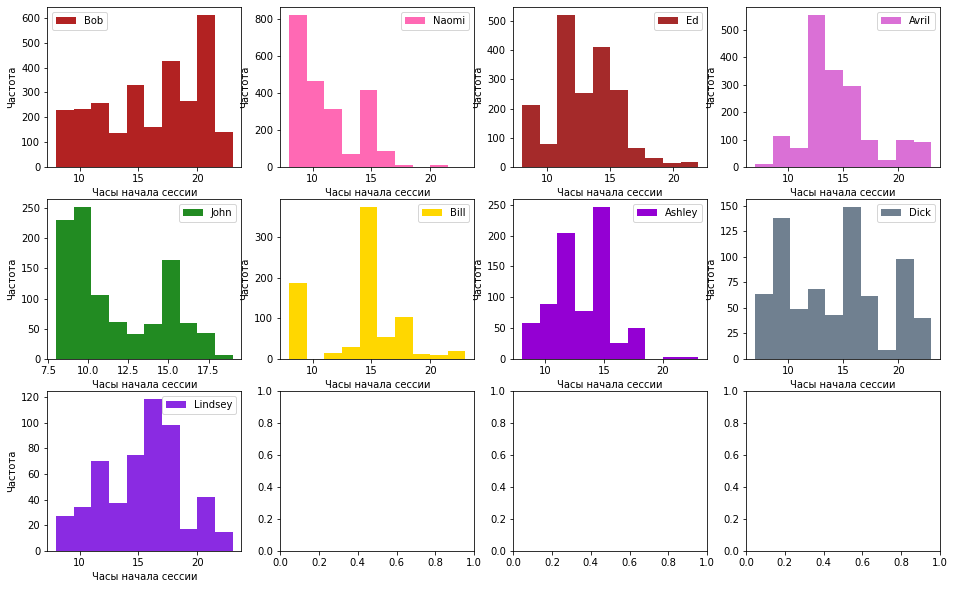

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

users = train_data_10users['target'].value_counts().index.to_list()
# как вариант, можно и по-другому
for idx, user in  enumerate(users):
    train_data_10users[train_data_10users['target']==user]['start_hour'].plot(kind='hist', ax=axes[idx//4][idx%4], color=color_dic[user], legend=True)
    axes[idx//4, idx%4].set_xlabel('Часы начала сессии')
    axes[idx//4, idx%4].set_ylabel('Частота')
    axes[idx//4, idx%4].legend([user])

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

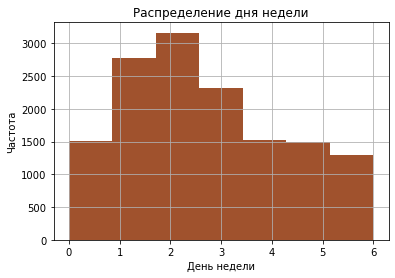

In [19]:
train_data_10users['day_of_week'].hist(color = 'sienna', bins=7)
plt.ylabel('Частота')
plt.xlabel('День недели')
plt.title('Распределение дня недели')
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

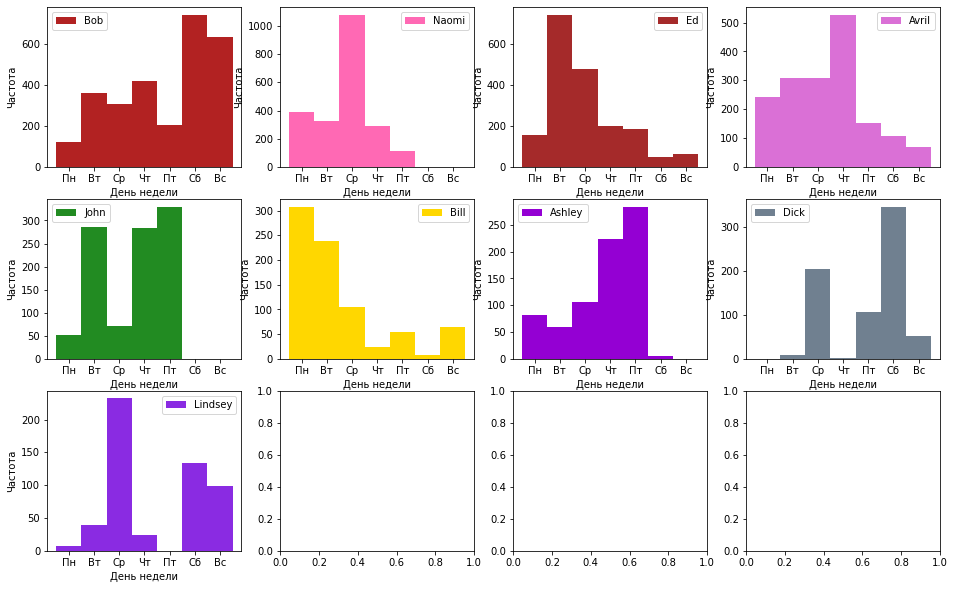

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

users = train_data_10users['target'].value_counts().index.to_list()
# как вариант, можно и по-другому
for idx, user in  enumerate(users):
    train_data_10users[train_data_10users['target']==user]['day_of_week'].plot(kind='hist', ax=axes[idx//4][idx%4], color=color_dic[user], legend=True, bins=np.arange(-0.5,7,1), xticks=range(7))
    axes[idx//4, idx%4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб',  'Вс'])
    axes[idx//4, idx%4].set_xlabel('День недели')
    axes[idx//4, idx%4].set_ylabel('Частота')
    axes[idx//4, idx%4].legend([user])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

1. Mary-Kate - больше всего проводит времени в пятницу и субботу. В выходные отдыхает. В основном дневное время. Чаще всего посещает одни и те же сайты. 
2. Ashley - больше всего активность в середине недели и на выходных. В пятницу отдыхает. Пик приходится на середину - вторую половину дня. Чаще всего посещает одни и те же сайты. 
3. Lindsey - больше всего активность начале недели и пик в середине недели. К концу недели активность падает. Пик приходится на первую половину дня. Чаще всего посещает одни и те же сайты, но часто и новые.
4. Naomi - больше всего активность со вторник по четверг. Воскресенье и понедельник отдыхает. Пик приходится на середину дня. Часто всего посещает одни и те же сайты, но часто и новые.
5. Avril - больше всего активность в конце недели. Понедельник и пятница наименьшая активность. Пик приходится на ближе к концу дня. Чаще посещает новые сайты.
6. Bob - больше всего активность в начале недели, к концу падает. Пик приходится на утро и середину дня. Чаще всего посещает одни и те же сайты, но часто и новые.
7. Bill - больше всего активность во вторник, четверг и пятницу. В выходные отдыхает. Пик приходится на утро и середину дня. Чаще всего посещает одни и те же сайты, но часто и новые.
8. John - больше всего активность в середине недели, в пятницу и субботу. В понедельник отдыхает. Пик приходится на утро, середину дня и вечер. Часто посещает новые сайты.
9. Dick - пик активности во вторник, к концу недели падает. Пик приходится на середину дня. Чаще всего посещает одни и те же сайты. 
10. Ed - пик активности в середине недели и в воскресенье. Пик приходится на середину дня. Посещает и известные, и новые сайты.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [21]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq_10 = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [22]:
top10_freqs = [i[1] for i in list(site_freq_10.values())[:10]]
top10_sites = [i for i in list(site_freq_10.keys())[:10]]

In [23]:
top10_freqs, top10_sites

([8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089],
 ['s.youtube.com',
  'www.google.fr',
  'www.google.com',
  'mail.google.com',
  'www.facebook.com',
  'apis.google.com',
  'r3---sn-gxo5uxg-jqbe.googlevideo.com',
  'r1---sn-gxo5uxg-jqbe.googlevideo.com',
  'plus.google.com',
  'accounts.google.com'])

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

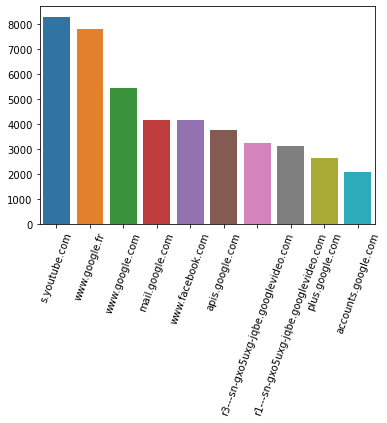

In [24]:
sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=70);

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [25]:
np.median(train_data_10users['session_timespan'])

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [26]:
np.median(train_data_10users['day_of_week'])

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [27]:
np.median(train_data_150users['start_hour'])

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [28]:
np.median(train_data_150users['unique_sites'])

7.0

**Cохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*). Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [29]:
selected_features_10users = train_data_10users.drop('target',axis=1).columns.to_list()
selected_features_150users = train_data_150users.drop('target',axis=1).columns.to_list() 

In [30]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)